In [1]:
import codecs

import pandas as pd 
import numpy as np

from scipy import stats

import ast

from math import cos, asin, sqrt

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import re
import os

import pandas as pd 
import numpy as np

from functools import partial 

In [4]:
import shutil
import os

In [5]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from wordcloud import WordCloud 
from itertools import chain

In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [9]:
import sys
from os.path import dirname
UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths, coordinates_bounds

In [10]:
### Limpieza de la data cruda

In [11]:
## Lista los enlaces de publicaciones que sabemos deberian excluirse

UNUSUAL_VALUES = ["https://www.fincaraiz.com.co/apartamento-en-venta/manizales/laureles-det-5488282.aspx"]

In [12]:
## Para verificar si un campo quedo vacío usaria series.isna()
def check_field(fn, e):
    try:
        return fn(e)
    except:
        return None
    
check_float = partial(check_field, float)
check_int = partial(check_field, int)

In [13]:
### La variable surface habla de el area del inmueble

surface_formatter = lambda e: e.replace('m²', '').replace(',', '.').strip()

In [14]:
### La variable price es el valor del inmueble en millones de pesos

price_formatter = lambda e: e.replace('$','').replace('.', '').strip()
price_cast = lambda e: None if e == None else e/1000000

In [15]:
### Rooms es al cantidad de habitaciones del inmueble

rooms_formatter = lambda e: e.replace('Habitaciones:','').strip()

In [16]:
### Baths es al cantidad de baños del inmueble

baths_formatter = lambda e: e.replace('Baños:','').strip()

In [17]:
### Baths es al cantidad de baños del inmueble

garages_formatter = lambda e: e.replace('Parqueaderos:','').strip()

In [18]:
### Both latitude and longitud appear under coordinates

def get_lat_lon(e, pattern=r'lat:([-\d\.]+),lon:([-\d\.]+)'):
    r = re.search(r'lat:([-\d\.]+),lon:([-\d\.]+)', e)
    if r == None:
        return ['0', '0']
    return [r.group(1), r.group(2)]

latitude_formatter = lambda e: get_lat_lon(e)[0]
longitude_formatter = lambda e: get_lat_lon(e)[1]
coordinate_cast = lambda e: None if e == '0' else float(e)

In [19]:
## Algunos apartamentos tienen un costo asociado que es el de adminitración

def get_admon(e, pattern = r'Adm.n:\$([\d\,]+)\w.*'):
    r = re.search(pattern, e)
    if r == None:
        return None
    else:
        return r.group(1).replace(",", "")

In [20]:
## El estrato es una variable importante

def get_estrato(e, pattern = r'Estrato:(\d)\w.*'):
    r = re.search(pattern, e)
    if r != None:
        return r.group(1)
    return r

In [21]:
## La antiguedad del inmueble puede indicar si es necesario hacer arreglos, o el tiempo que va a seguir rentando

def get_antiguedad(e, pattern = r'Antig.edad:([\w\s]+)\sa.os'):
    r = re.search(pattern, e)
    if r != None:
        return r.group(1)
    return r

In [22]:
## Finca raiz tiene un identificador unico en la URL, con esto se pueden filtrar publicaciones duplicadas pero no
## aún no sabemos si la misma casa aparece en 2 publicaciones.

def fincaraiz_id(e):
    pattern = r'det-(\d+)\.aspx'
    r = re.search(pattern, e)
    if r != None:
        return r.group(1)
    return r

In [23]:
def filter_unusual_values(df, UNUSUAL_VALUES):
    if UNUSUAL_VALUES == None:
        return df
    unusual_condition = (UNUSUAL_VALUES[0] == df["url"])
    for i in range(1, len(UNUSUAL_VALUES)):
        unusual_condition = unusual_condition | (UNUSUAL_VALUES[i] == df["url"])
    df = df.loc[~unusual_condition]
    df.reindex()
    return df

In [24]:
def cleanUpValues(df):
    df = df.copy()
    df.loc[:, "surface"] = df["surface"].apply(surface_formatter).apply(check_float)
    df.loc[:, "price"] = df["price"].apply(price_formatter).apply(check_float).apply(price_cast)
    df.loc[:, "rooms"] = df["rooms"].apply(rooms_formatter).apply(check_int)
    df.loc[:, "baths"] = df["baths"].apply(baths_formatter).apply(check_int)
    df.loc[:, "garages"] = df["garages"].apply(garages_formatter).apply(check_int)
    df.loc[:, "latitude"] = df["coordinates"].apply(latitude_formatter).apply(coordinate_cast)
    df.loc[:, "longitude"] = df["coordinates"].apply(longitude_formatter).apply(coordinate_cast)
    df.loc[:, "admon"] = df["additional_info"].apply(get_admon).apply(check_int)
    df.loc[:, "estrato"] = df["additional_info"].apply(get_estrato).apply(check_int)
    df.loc[:, "antiguedad"] = df["additional_info"].apply(get_antiguedad)
    df.loc[:, "fid"] = df["url"].apply(fincaraiz_id)
    
    final = df.loc[:, ["surface", "rooms", "baths", "garages", "price", "latitude", "description",
                      "longitude", "location", "url", "admon", "estrato", "antiguedad", "fid"]]
    final = final.drop_duplicates(["fid"])
    final.index = list(range(final.shape[0]))
    final = final.reindex()
    
    return final

In [25]:
def read_data_full(filename):
    ## Carga resultado del crawling the finca raiz
    posts = pd.read_parquet(filename)    
    """
    ### Pueden haber campos faltantes
    
    La idea es identificar estas publicaciones para completar la información y poderles dar un trato diferente, 
    si un campo viene vacio o no tiene sentido la idea es configurarlo en None, de esta forma el código que sigue
    a continuación puede identificar facilment el caso. 
    """
    publications = cleanUpValues(posts)
    publications = filter_unusual_values(publications, UNUSUAL_VALUES)
    return publications

In [26]:
### Utilidades para el analisis exploratorio de datos

In [27]:
false_validator = lambda e: False

def eda_non_valid(df, validator):
    results = []
    
    final_validator = {}
    for column in df.columns:
        final_validator[column] = false_validator
        
    final_validator.update(validator)
    
    non_valid_filter = df[df.columns[0]] == df[df.columns[0]]
    for column in df.columns:
        nan_condition = df[column].isna()
        valid_condition = df[column].apply(final_validator[column])
        non_valid_filter = non_valid_filter & (~nan_condition) & (~valid_condition)
        results.append([column, df.loc[nan_condition].shape[0], df.loc[~nan_condition].loc[valid_condition].shape[0]])
    
    pd_results = pd.DataFrame(results)
    pd_results.columns = ["column", "nan", "non_valid"]
    return pd_results, df.loc[non_valid_filter]

def validators_builder(coordinates):    
    coordinate_validator = lambda e, axis: coordinates[axis]['lower'] > e or coordinates[axis]['upper'] < e

    return {
        'latitude': lambda e: coordinate_validator(e, 'lat'),
        'longitude': lambda e: coordinate_validator(e, 'lon')
    }

def generic_bars_props_2(fig, x, y, categories, label_template):
    ax = fig.add_subplot(1,1,1)

    N = len(x)
    width=0.5
    x_axis = range(1,N+1)

    colors = ["blue", "green"] 
    for i in range(2):
        x_result = list(map(lambda e: N*width*e + width*i - width/2.0, x_axis))
        ax.bar(x_result, y[i], width=width, label=label_template + str(categories[i]), color=colors[i])

    x_ticks = list(map(lambda e: N*width*e, x_axis))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    plt.legend(loc='best')
    
def plot_valid_bars(df, builder):
    fincaraiz_validator = builder()
    
    df_valid, valid_samples = eda_non_valid(df, fincaraiz_validator)
    df_valid.head()
    
    generic_bars_props_2(
        plt.figure(figsize=(16, 4)),
        df_valid['column'],
        [
            df_valid["nan"],
            df_valid["non_valid"]
        ],
        [
            "nan",
            "non valid"
        ],
        "error: "
    )
    
    return valid_samples

In [28]:
def generic_bars(ax, x, y, label):
    N = len(x)
    width=0.5
    x_axis = range(1,N+1)

    x_result = list(map(lambda e: N*width*e, x_axis))
    ax.bar(x_result, y, width=width, label="# " + label, color="green")

    x_ticks = list(map(lambda e: N*width*e, x_axis))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x)

    ax.set_title(label)
    ax.legend(loc='best')
    
def plot_discrete_columns(df):
    fig = plt.figure(figsize=(16, 20))

    discrete_columns = ["rooms", "baths", "garages", "estrato", "antiguedad"]
    for i in range(1, len(discrete_columns) +  1):
        column = discrete_columns[i - 1]
        single_column = df[column].value_counts()

        ax = fig.add_subplot(len(discrete_columns),1,i)
        generic_bars(
            ax,
            single_column.index,
            single_column.values,
            column
        )

In [29]:
def load_posts(input_path, city, property_type, post_type):
    df = read_data_full(input_path)
    df.loc[:, "city"] = city
    df.loc[:, "property_type"] = property_type
    df.loc[:, "post_type"] = post_type
    return df

def write_posts(df, output_path):
    basename = output_path.split("/")[:-1]
    basename = "/".join(basename)
    
    try:
        shutil.rmtree(basename)
    except FileNotFoundError as e:
        print("First time running this script")
    
    os.makedirs(basename)
    
    print(output_path)
    df.to_parquet(output_path)

In [30]:
if __name__ == "__main__":
    city = "manizales"
    property_type = "apartamentos"
    post_type = "arriendo"
    
    #city, property_type, post_type = check_args()
    base_path = os.environ.get('REPO')
    
    input_path, output_path = gen_paths(city, property_type, post_type)
    
    input_path = base_path + input_path
    output_path = base_path + output_path

In [31]:
MSG = """
Hay {} publicaciones de {} en total
"""

posts = load_posts(input_path, city, property_type, post_type)
print(MSG.format(posts.shape[0], post_type))
posts.head()


Hay 1180 publicaciones de arriendo en total



,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type
0,65.0,2.0,1.0,NaN,0.65,5.058869,Arrienda apartamento en el barrio La Sultana s...,-75.475807,Manizales La Sultana,https://www.fincaraiz.com.co/apartamento-en-ar...,NaN,4.0,None,5469476,manizales,apartamentos,arriendo
1,55.0,2.0,1.0,NaN,0.80,5.058840,Apartamento con excelente iluminación muy bien...,-75.485168,Manizales La Rambla,https://www.fincaraiz.com.co/apartamento-en-ar...,NaN,5.0,1 a 8,5357660,manizales,apartamentos,arriendo
2,80.0,2.0,2.0,1.0,1.90,5.052409,Administra Bienes Raíces ofrece para arrendami...,-75.485085,Manizales Camelia,https://www.fincaraiz.com.co/apartamento-en-ar...,NaN,6.0,1 a 8,5670358,manizales,apartamentos,arriendo
3,90.0,3.0,2.0,NaN,1.70,NaN,Apartamento con buena iluminación con amplios ...,NaN,Manizales Centro,https://www.fincaraiz.com.co/apartamento-en-ar...,NaN,5.0,None,5212937,manizales,apartamentos,arriendo
4,100.0,4.0,2.0,NaN,1.25,5.053482,Espacioso apartamento en un tercer piso con gr...,-75.495567,Manizales Fátima,https://www.fincaraiz.com.co/apartamento-en-ar...,NaN,3.0,1 a 8,5468657,manizales,apartamentos,arriendo


## Exploración general

In [32]:
builder = lambda : validators_builder(coordinates_bounds[city])

condition = (posts["city"] == city) & (posts["property_type"] == property_type) \
                  & (posts["post_type"] == post_type)

### Rango de valores y campos faltantes

El campo menos comun es el de la administración, seguido por el de garages y la anteguedad

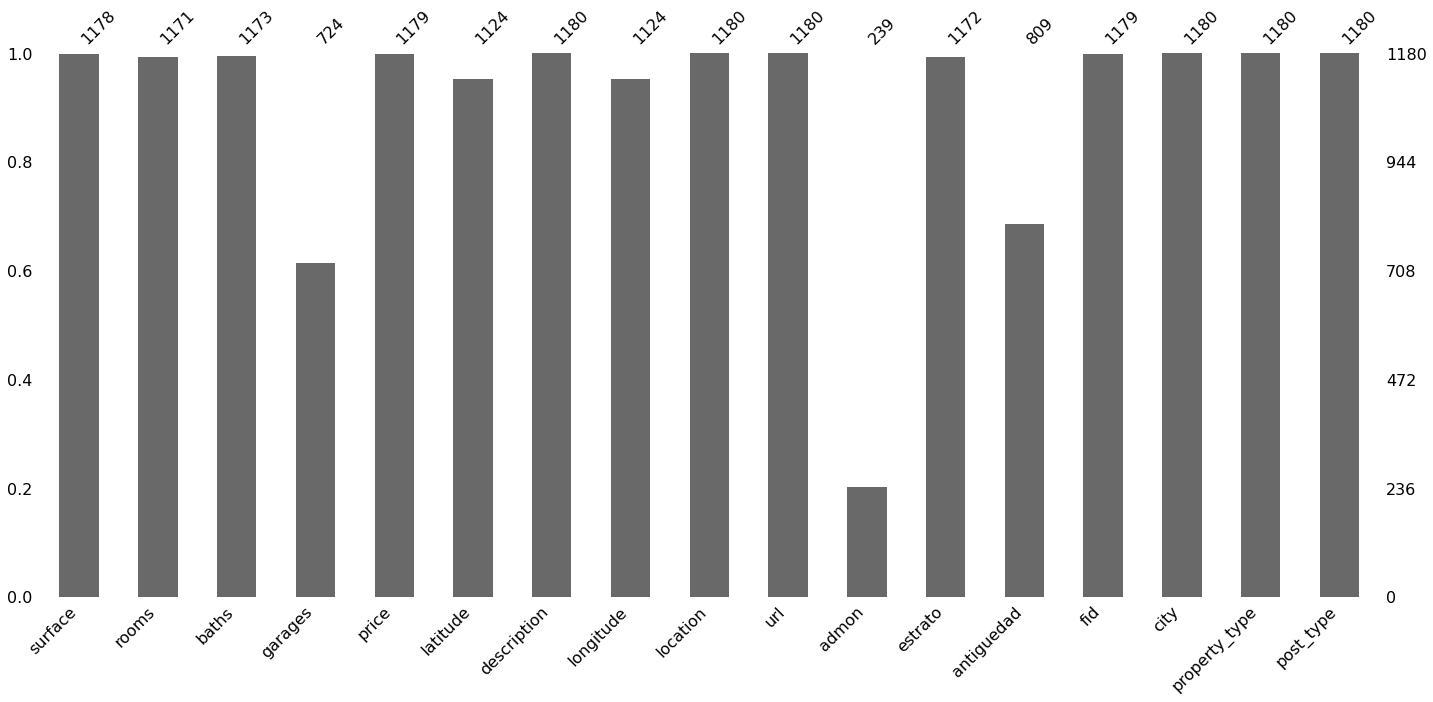

In [33]:
%matplotlib inline

msno.bar(posts)

## Exploración de variables de texto

In [34]:
post_words = posts["description"].apply(lambda e: nltk.word_tokenize(e)) \
        .apply(lambda e: list(filter(
    lambda e: e not in stopwords.words('spanish') and \
                e not in [',', '.', '!', '..', ':', ';'] and \
            e.isalpha(), e)))
post_words

0       [Arrienda, apartamento, barrio, La, Sultana, v...
1       [Apartamento, excelente, iluminación, bien, ub...
2       [Administra, Bienes, Raíces, ofrece, arrendami...
3       [Apartamento, buena, iluminación, amplios, esp...
4       [Espacioso, apartamento, tercer, piso, gran, i...
                              ...                        
1175    [Vista, Inmobiliaria, ofrece, venta, apartamen...
1176    [Ofrecemos, arrendamiento, espectacular, apart...
1177    [Área, mtrs, apartamento, duplex, iluminado, c...
1178    [Presentamos, arriendo, apartamento, ubicado, ...
1179                                        [description]
Name: description, Length: 1180, dtype: object

In [35]:
## https://stackoverflow.com/questions/35004945/reduce-function-for-series

tokenized_words = list(chain.from_iterable(post_words.values))

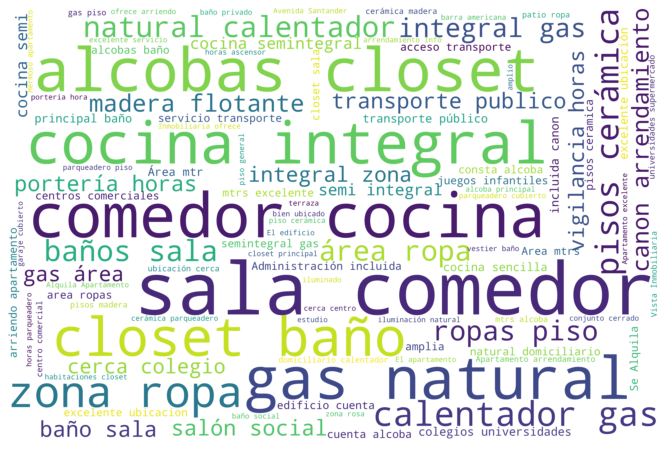

In [36]:
word_cloud_text = " ".join(tokenized_words)
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                    scale=10, width=900, height=600).generate(word_cloud_text)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

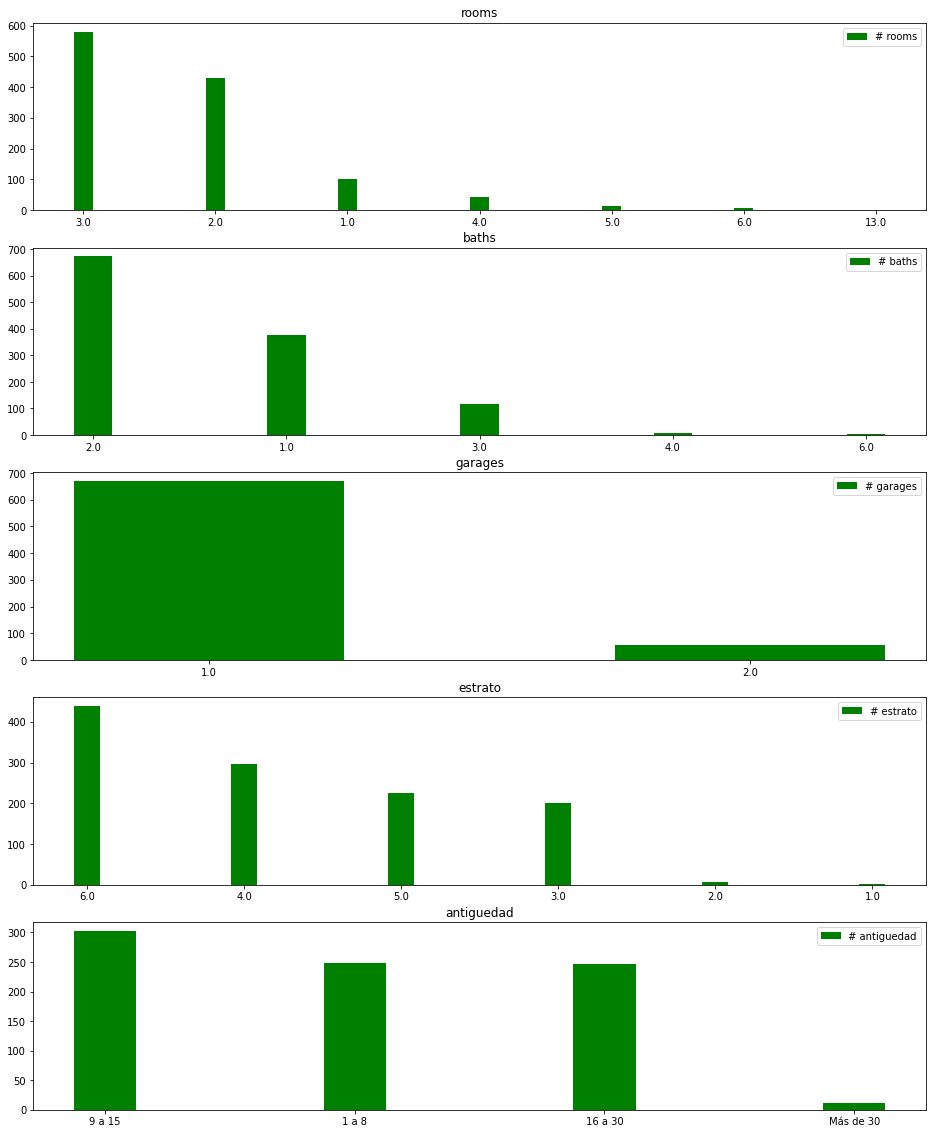

In [37]:
%matplotlib inline

plot_discrete_columns(posts)

,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type
8,48.0,2.0,2.0,1.0,0.800000,5.052778,"Area de 48 mtrs, excelente ubicacion, cerca de...",-75.483383,Manizales SAN RAFAEL,https://www.fincaraiz.com.co/apartamento-en-ar...,200000.0,5.0,9 a 15,5254760,manizales,apartamentos,arriendo
31,52.0,2.0,1.0,1.0,0.740000,5.059853,Apartaestudio en arrendamiento con un área de ...,-75.487831,Manizales AVENIDA SANTANDER,https://www.fincaraiz.com.co/apartamento-en-ar...,160000.0,6.0,16 a 30,5634573,manizales,apartamentos,arriendo
42,58.0,3.0,2.0,1.0,1.111380,5.061791,"Area de 58 mtrs, excelente ubicacion, cerca de...",-75.470924,Manizales LA SULTANA,https://www.fincaraiz.com.co/apartamento-en-ar...,188620.0,4.0,16 a 30,5198326,manizales,apartamentos,arriendo
46,70.0,2.0,2.0,1.0,1.470000,5.036569,"Apartamento con 70 mts, 2 alcobas, 1 closet, 1...",-75.473038,Manizales AVENIDA ALBERTO MENDOZA,https://www.fincaraiz.com.co/apartamento-en-ar...,180000.0,6.0,1 a 8,5413772,manizales,apartamentos,arriendo
66,69.0,2.0,2.0,1.0,1.077000,5.061186,Apartamento para arrendar en Versalles con un ...,-75.499023,Manizales VERSALLES,https://www.fincaraiz.com.co/apartamento-en-ar...,173000.0,5.0,16 a 30,5676037,manizales,apartamentos,arriendo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,80.0,3.0,2.0,1.0,0.688600,5.048331,Apartamento para arrendar en el Alta suiza con...,-75.479958,Manizales ALTA SUIZA,https://www.fincaraiz.com.co/apartamento-en-ar...,261400.0,5.0,16 a 30,5688802,manizales,apartamentos,arriendo
1142,86.0,3.0,2.0,1.0,1.147000,5.062935,Apartamento en arrendamiento en Versalles con ...,-75.502655,Manizales VERSALLES,https://www.fincaraiz.com.co/apartamento-en-ar...,253000.0,5.0,9 a 15,5653342,manizales,apartamentos,arriendo
1147,1.0,3.0,2.0,1.0,0.868114,5.054071,"3 alcobas, 2 baños, sala comedor, cocina semin...",-75.484612,Manizales PALERMO,https://www.fincaraiz.com.co/apartamento-en-ar...,171700.0,6.0,16 a 30,5542880,manizales,apartamentos,arriendo
1162,75.0,3.0,2.0,1.0,1.027000,5.066080,"3 Alcobas, Closet, 2 Baños, Sala comedor, Coci...",-75.497513,Manizales SAN JORGE,https://www.fincaraiz.com.co/apartamento-en-ar...,223000.0,4.0,16 a 30,5474334,manizales,apartamentos,arriendo


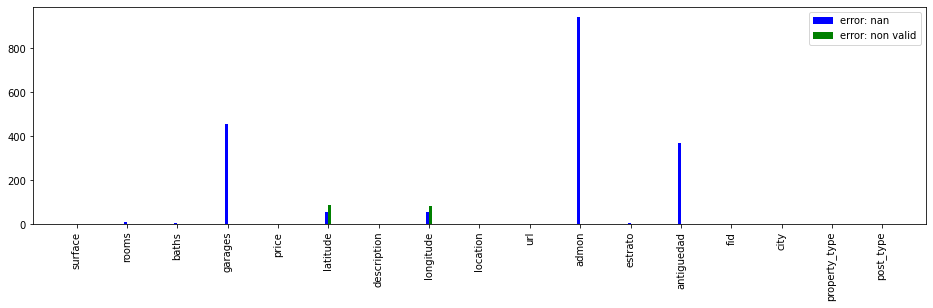

In [38]:
%matplotlib inline

## Se filtran las publicaciones que tienen nulos o no complen con los validadores

plot_valid_bars(posts, builder)

### Campos en que se conoce el significado de None

Varias publicaciones no continen algunos campos, pero la asusencia del campo no significa que se desconosca su valor, en estos casos voy a asumir que el valor es cero

In [39]:
clean_posts = posts.copy()

clean_posts.loc[clean_posts["admon"].isna(), "admon"] = 0
clean_posts.loc[clean_posts["garages"].isna(), "garages"] = 0

In [40]:
## Antigueda es un string, así que voy a conservar las publicaciones pero en este caso le voy a poner desconocido

clean_posts.loc[clean_posts["antiguedad"].isna(), "antiguedad"] = "desconocido"

,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type
0,65.0,2.0,1.0,0.0,0.65,5.058869,Arrienda apartamento en el barrio La Sultana s...,-75.475807,Manizales La Sultana,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,4.0,desconocido,5469476,manizales,apartamentos,arriendo
1,55.0,2.0,1.0,0.0,0.80,5.058840,Apartamento con excelente iluminación muy bien...,-75.485168,Manizales La Rambla,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,5.0,1 a 8,5357660,manizales,apartamentos,arriendo
2,80.0,2.0,2.0,1.0,1.90,5.052409,Administra Bienes Raíces ofrece para arrendami...,-75.485085,Manizales Camelia,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,6.0,1 a 8,5670358,manizales,apartamentos,arriendo
4,100.0,4.0,2.0,0.0,1.25,5.053482,Espacioso apartamento en un tercer piso con gr...,-75.495567,Manizales Fátima,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,3.0,1 a 8,5468657,manizales,apartamentos,arriendo
5,41.0,3.0,1.0,0.0,0.50,5.070275,"Area de 41 mtrs, excelente ubicacion, muy ilum...",-75.513817,Manizales SANTOS,https://www.fincaraiz.com.co/apartamento-en-ar...,0.0,3.0,16 a 30,5174681,manizales,apartamentos,arriendo


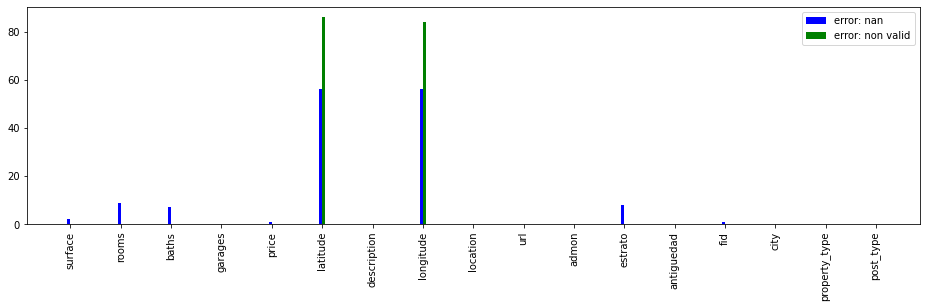

In [41]:
%matplotlib inline

## Se filtran las publicaciones que tienen nulos o no complen con los validadores

clean_posts = plot_valid_bars(clean_posts, builder)
clean_posts.head()

In [42]:
# Precio por metro 2

clean_posts.loc[:, "price_m2"] = clean_posts["price"]/clean_posts["surface"]

In [43]:
MSG = """
Hay {} publicaciones de {} validas
""".format(
    clean_posts.shape[0],
    post_type
)

print(MSG)


Hay 1027 publicaciones de arriendo validas



In [44]:
write_posts(clean_posts, output_path)

First time running this script
/home/runner/notebooks/web-scraping/data/posts/2020-09-26/clean/apartamentos/manizales-arriendo/posts.parquet
